In [156]:
import pandas as pd
import numpy as np
from pvlib import pvsystem, modelchain, location, iotools

In [165]:
def get_solar_ac_dataframe(latitude, longitude):
    """
    Calculate the AC output of a PV system based on latitude and longitude.

    Parameters:
    - latitude (float): Latitude of the location
    - longitude (float): Longitude of the location

    Returns:
    - ac (pd.DataFrame): Dataframe containing the AC output of the PV system
    """
    
    # Define array configuration for a single axis tracker
    array_kwargs_tracker = dict(
        module_parameters=dict(pdc0=1, gamma_pdc=-0.004),
        temperature_model_parameters=dict(a=-3.56, b=-0.075, deltaT=3)
    )

    # Create the PV system and model chain
    arrays = [
        pvsystem.Array(pvsystem.SingleAxisTrackerMount(), **array_kwargs_tracker),
    ]
    
    # Set the location using the input latitude and longitude
    loc = location.Location(latitude, longitude)
    
    # Define the PV system and inverter parameters
    system = pvsystem.PVSystem(arrays=arrays, inverter_parameters=dict(pdc0=1))
    
    # Create the model chain with the physical AOI model and no spectral losses
    mc = modelchain.ModelChain(system, loc, aoi_model='physical', spectral_model='no_loss')
    
    # Fetch weather data using PVGIS
    weather = iotools.get_pvgis_tmy(latitude, longitude)[0]
    
    # Run the model with the weather data
    mc.run_model(weather)
    
    # Return the AC output as a pandas DataFrame
    return mc.results.ac
    

def scale_solar_generation(df, installed_capacity):
    """
    Scale the solar generation based on the installed capacity.
    """
    df['scaled_generation'] = df['p_mp'] * installed_capacity
    return df


def simulate_battery_operation(df, battery_capacity, initial_battery_charge, load):
    """
    Simulate the charging/discharging of the battery, calculate curtailed solar and unmet load.
    """
    battery_storage = initial_battery_charge  # starting battery state
    curtailed_solar = []
    unmet_load = []
    battery_storage_list = []
    
    # Loop through the dataset and simulate battery operation
    for i, row in df.iterrows():
        scaled_gen = row['scaled_generation']
        
        # Calculate excess power and deficit
        if scaled_gen > load:
            excess_power = scaled_gen - load
            available_storage = battery_capacity - battery_storage
            stored_energy = min(excess_power, available_storage)
            curtailed = excess_power - stored_energy
            battery_storage += stored_energy
            unmet = 0
        else:
            deficit = load - scaled_gen
            discharge = min(deficit, battery_storage)
            battery_storage -= discharge
            unmet = deficit - discharge
            curtailed = 0
        
        # Record the results
        curtailed_solar.append(curtailed)
        unmet_load.append(unmet)
        battery_storage_list.append(battery_storage)

    # Add columns to dataframe
    df['battery_storage'] = battery_storage_list
    df['curtailed_solar'] = curtailed_solar
    df['unmet_load'] = unmet_load
    df['load_unmet'] = df['unmet_load'] > 0

    return df

def process_solar_data(df, installed_capacity, battery_capacity, initial_battery_charge, load):
    """    
    Parameters:
    - installed_capacity: Solar installation capacity in MW
    - battery_capacity: Battery storage capacity in MWh
    - initial_battery_charge: Initial charge of the battery in MWh
    - load: Constant load in MW to be met by solar and battery

    Returns:
    - A pandas DataFrame with the results of the simulation.
    """
    # Step 1: Scale the solar generation based on the installed capacity
    df = scale_solar_generation(df, installed_capacity)
    
    # Step 2: Simulate the battery operation, including curtailed solar and unmet load
    df = simulate_battery_operation(df, battery_capacity, initial_battery_charge, load)
    
    return df


def find_all_solar_battery_combinations_with_cost(latitude, longitude, load, solar_range, battery_range, solar_cost_per_mw, battery_cost_per_mwh, perf_target = 90):
    """
    Find all combinations of solar and battery capacity that meet the load for at least 90% of the year,
    and calculate the cost for each valid combination.

    Parameters:
    - load: Constant load in MW to be met by solar and battery
    - solar_range: Tuple (min_solar_capacity, max_solar_capacity)
    - battery_range: Tuple (min_battery_capacity, max_battery_capacity)
    - solar_cost_per_mw: Cost per MW of solar capacity ($/MW)
    - battery_cost_per_mwh: Cost per MWh of battery storage ($/MWh)

    Returns:
    - A list of tuples (solar_capacity, battery_capacity, performance, total_cost) that meet the load for at least 90% of the hours
    """
    df = get_solar_ac_dataframe(latitude, longitude)
    df = df.reset_index()
    df.columns = ['time(UTC)', 'p_mp']
    df['time(UTC)'] = pd.to_datetime(df['time(UTC)'])
    min_solar_capacity, max_solar_capacity = solar_range
    min_battery_capacity, max_battery_capacity = battery_range
    
    valid_combinations = []  # To store all combinations that meet the 90% condition
    
    # Define search steps (you can adjust the step sizes for finer or coarser search)
    solar_capacities = np.arange(min_solar_capacity, max_solar_capacity + 1, 1)
    battery_capacities = np.arange(min_battery_capacity, max_battery_capacity + 1, 1)
    
    # Loop over all combinations of solar and battery capacities
    for solar_capacity in solar_capacities:
        for battery_capacity in battery_capacities:
            # Set initial battery charge equal to the battery capacity for each combination
            initial_battery_charge = battery_capacity
            
            # Simulate the system with the current solar and battery capacities
            result_df = process_solar_data(df, solar_capacity, battery_capacity, initial_battery_charge, load)
            
            # Calculate the percentage of hours where load is met
            hours_with_unmet_load = result_df['load_unmet'].sum()
            total_hours = len(result_df)
            performance = (total_hours - hours_with_unmet_load) / total_hours * 100
            
            # Check if this combination meets the 90% target
            if performance >= perf_target:
                # Calculate the cost for this combination
                total_cost = (solar_capacity * solar_cost_per_mw) + (battery_capacity * battery_cost_per_mwh)
                valid_combinations.append((solar_capacity, battery_capacity, performance, total_cost))

    return valid_combinations

In [178]:
#El Paso TX
latitude = 31.9 
longitude = -106.2

#Yuma, AZ
#latitude = 32.6 
#longitude = -114.7

load = 1  # MW
solar_range = (1, 20)  # MW
battery_range = (0, 40)  # MWh
solar_cost_per_mw = 1000 *1000  # $/MW, assuming $1000/kW
battery_cost_per_mwh = 350 * 1000  # $/MWh, assuming $350/kWh

valid_combinations_with_cost = find_all_solar_battery_combinations_with_cost(latitude, longitude, load, solar_range, battery_range, solar_cost_per_mw, battery_cost_per_mwh)

print("Valid Combinations (Solar Capacity, Battery Capacity, Performance %, Total Cost $):")

# Sort the valid_combinations_with_cost by the total_cost (the 4th element in the tuple)
sorted_combinations = sorted(valid_combinations_with_cost, key=lambda x: x[3])

# Print the sorted results
for solar_capacity, battery_capacity, performance, total_cost in sorted_combinations[0:20]:
    print(f"Solar: {solar_capacity} MW, Battery: {battery_capacity} MWh, Performance: {performance:.2f}%, Total Cost: ${total_cost:.2f}")


Valid Combinations (Solar Capacity, Battery Capacity, Performance %, Total Cost $):
Solar: 4 MW, Battery: 14 MWh, Performance: 91.14%, Total Cost: $8900000.00
Solar: 5 MW, Battery: 12 MWh, Performance: 90.06%, Total Cost: $9200000.00
Solar: 4 MW, Battery: 15 MWh, Performance: 91.84%, Total Cost: $9250000.00
Solar: 5 MW, Battery: 13 MWh, Performance: 92.65%, Total Cost: $9550000.00
Solar: 4 MW, Battery: 16 MWh, Performance: 92.16%, Total Cost: $9600000.00
Solar: 5 MW, Battery: 14 MWh, Performance: 94.20%, Total Cost: $9900000.00
Solar: 4 MW, Battery: 17 MWh, Performance: 92.50%, Total Cost: $9950000.00
Solar: 6 MW, Battery: 12 MWh, Performance: 91.45%, Total Cost: $10200000.00
Solar: 5 MW, Battery: 15 MWh, Performance: 95.14%, Total Cost: $10250000.00
Solar: 4 MW, Battery: 18 MWh, Performance: 92.72%, Total Cost: $10300000.00
Solar: 6 MW, Battery: 13 MWh, Performance: 94.10%, Total Cost: $10550000.00
Solar: 5 MW, Battery: 16 MWh, Performance: 95.55%, Total Cost: $10600000.00
Solar: 4 MW

In [158]:
years = 20
discount_rate = 0.06
electric_price = 5 #cents/kwh, target rate for data centers per https://www.blsstrategies.com/insights-press/power-requirements-energy-costs-and-incentives-for-data-centers
grid_initial_cost = electric_price/100. * 1000 * 365 * 24
grid_ongoing_cost = grid_initial_cost
solar_initial_cost = sorted_combinations[0][3]
solar_ongoing_cost = grid_cost * (1-(sorted_combinations[0][2]/100)) #update to dynamically use matching for grid cost


def calculate_npv_corrected(initial_cost, ongoing_cost, discount_rate, years):
    """Calculate the Net Present Value (NPV) of a project, accounting for costs."""
    npv = -initial_cost  # Initial cost is incurred at year 0
    for t in range(1, years + 1):
        npv -= ongoing_cost / (1 + discount_rate) ** t  # Subtract ongoing costs, discounting for each year
    return npv


print(f"Grid initial cost: ${grid_initial_cost}")
print(f"Solar initial cost: ${solar_initial_cost}")
print(f"Solar initial premium: {np.round(solar_initial_cost / grid_initial_cost, 1)}x")

npv_grid_corrected = calculate_npv_corrected(grid_initial_cost, grid_ongoing_cost, discount_rate, years)
npv_solar_corrected = calculate_npv_corrected(solar_initial_cost, solar_ongoing_cost, discount_rate, years)

print(f"")
print(f"Grid NPV at {np.round(discount_rate*100,0)}% discount rate over {years} years: ${np.round(npv_grid_corrected,0)}")
print(f"Solar NPV at {np.round(discount_rate*100,0)}% discount rate over {years} years: ${np.round(npv_solar_corrected,0)}")
print(f"NPV solar premium: ${np.round(npv_solar_corrected-npv_grid_corrected,0)} ({np.round(npv_solar_corrected/npv_grid_corrected*100-100,0)}% higher)")


Grid initial cost: $438000.0
Solar initial cost: $8900000
Solar initial premium: 20.3x

Grid NPV at 6.0% discount rate over 20 years: $-5461825.0
Solar NPV at 6.0% discount rate over 20 years: $-9345033.0
NPV solar premium: $-3883207.0 (71.0% higher)


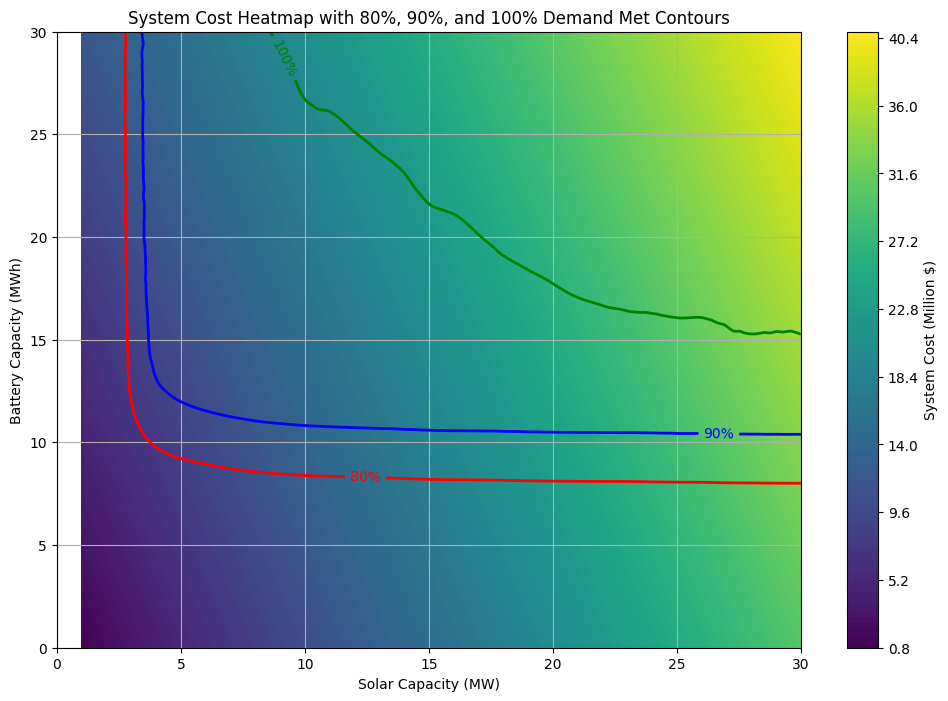

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.ticker as ticker


valid_combinations_with_cost = find_all_solar_battery_combinations_with_cost(latitude, longitude, load, solar_range, battery_range, solar_cost_per_mw, battery_cost_per_mwh, perf_target=0)
data = sorted(valid_combinations_with_cost, key=lambda x: x[3])

# Extract data into arrays
solar_capacities = np.array([item[0] for item in data])
battery_capacities = np.array([item[1] for item in data])
percentages = np.array([item[2] for item in data])
costs = np.array([item[3] for item in data])

# Convert costs to millions
costs_in_millions = costs / 1e6

# Create grid
xi = np.linspace(0, 30, 300)
yi = np.linspace(0, 30, 300)
X, Y = np.meshgrid(xi, yi)

# Interpolate data
Z_cost = griddata(
    (solar_capacities, battery_capacities), costs_in_millions, (X, Y), method='cubic'
)
Z_percentage = griddata(
    (solar_capacities, battery_capacities), percentages, (X, Y), method='cubic'
)

# Handle NaN values in Z_cost and Z_percentage
Z_cost = np.ma.array(Z_cost, mask=np.isnan(Z_cost))
Z_percentage = np.ma.array(Z_percentage, mask=np.isnan(Z_percentage))

# Plot
plt.figure(figsize=(12, 8))

# Plot the heatmap for cost in millions
cp = plt.contourf(X, Y, Z_cost, levels=100, cmap='viridis')
color_bar = plt.colorbar(cp, label='System Cost (Million $)')

# Optional: Format colorbar ticks
color_bar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# Define contour levels for percentage of demand met
contour_levels = [80, 90, 99.9]

# Overlay contour lines for specified percentages
CS = plt.contour(X, Y, Z_percentage, levels=contour_levels, colors=['red', 'blue', 'green'], linewidths=2)
plt.clabel(CS, inline=True, fontsize=10, fmt='%1.0f%%')

# Labels and title
plt.xlabel('Solar Capacity (MW)')
plt.ylabel('Battery Capacity (MWh)')
plt.title('System Cost Heatmap with 80%, 90%, and 100% Demand Met Contours')
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.grid(True)

plt.show()




In [177]:
#valid_combinations_with_cost = find_all_solar_battery_combinations_with_cost(latitude, longitude, load, solar_range, battery_range, solar_cost_per_mw, battery_cost_per_mwh, perf_target=0)
#data = sorted(valid_combinations_with_cost, key=lambda x: x[3])

# Step 1: Define the Parameters and Functions

# Given parameters
years = 20
discount_rate = 0.06  # 6% discount rate
electric_price = 5  # cents per kWh

# Calculate grid initial and ongoing costs
# Grid cost per year = electric_price (in $/kWh) * 1000 kWh/MWh * 365 days * 24 hours
# Since electric_price is in cents, divide by 100 to convert to dollars
grid_initial_cost = (electric_price / 100.0) * 1000 * 365 * 24
grid_ongoing_cost = grid_initial_cost

# Define the NPV calculation function
def calculate_npv_corrected(initial_cost, ongoing_cost, discount_rate, years):
    """Calculate the Net Present Value (NPV) of a project, accounting for costs."""
    npv = -initial_cost  # Initial cost is incurred at year 0
    for t in range(1, years + 1):
        npv -= ongoing_cost / (1 + discount_rate) ** t  # Subtract ongoing costs, discounting for each year
    return npv

# Step 2: Process Each Row in the Data

# Prepare a list to store the results
results = []

for row in data:
    solar_capacity = row[0]  # Solar capacity (MW)
    battery_capacity = row[1]  # Battery capacity (MWh)
    percent_demand_met = row[2]  # Percentage of demand met (%)
    solar_initial_cost = row[3]  # Initial cost for solar option ($)

    # Calculate the ongoing cost for the solar option
    # The ongoing cost is the grid cost adjusted for the percentage of demand met by solar
    solar_ongoing_cost = grid_ongoing_cost * (1 - (percent_demand_met / 100.0))

    # Calculate NPVs
    npv_grid_corrected = calculate_npv_corrected(grid_initial_cost, grid_ongoing_cost, discount_rate, years)
    npv_solar_corrected = calculate_npv_corrected(solar_initial_cost, solar_ongoing_cost, discount_rate, years)

    # Calculate the multiplier
    multiplier = (npv_solar_corrected / npv_grid_corrected) * 100 - 100  # As a percentage difference

    # Append the multiplier to the row
    result_row = row + (multiplier,)
    results.append(result_row)

# Step 3: Display or Store the Results

# Optionally, print the results
#for result in results:
#    print(f"Solar Capacity: {result[0]} MW, Battery Capacity: {result[1]} MWh, "
#          f"Percent Demand Met: {result[2]:.2f}%, Initial Cost: ${result[3]:,}, "
#          f"Multiplier: {result[4]:.2f}%")


Best configuration for 80% demand met: [3.00000000e+00 1.20000000e+01 8.00114155e+01 7.20000000e+06]
Best configuration for 90% demand met: [4.00000000e+00 1.40000000e+01 9.11415525e+01 8.90000000e+06]
Best configuration for 100% demand met: [1.20e+01 3.00e+01 1.00e+02 2.25e+07]


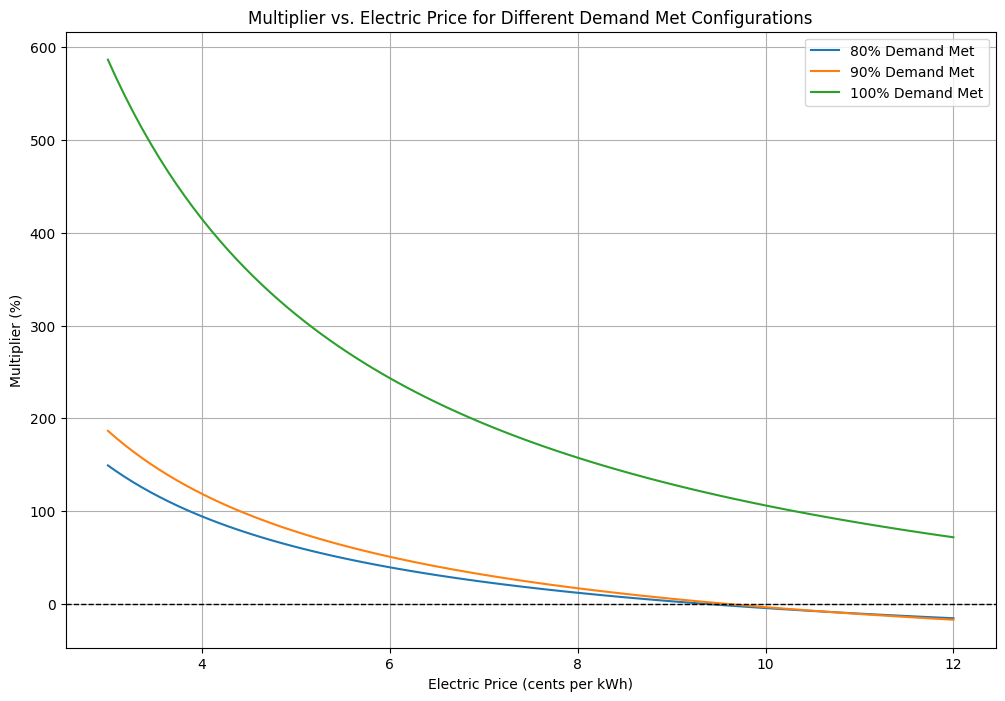

In [188]:
import numpy as np
import matplotlib.pyplot as plt

dispatch_multiplier = 2 #Increased grid electricity cost as % of demand met by behind the meter solar approaches 100%

# Convert data to a NumPy array
data_array = np.array(data)

# Define target percentages
target_percentages = [80, 90, 100]

# Prepare a dictionary to store the selected configurations
selected_configs = {}

for target in target_percentages:
    # Find configurations that meet or exceed the target percentage
    valid_configs = data_array[data_array[:,2] >= target]
    
    if valid_configs.size == 0:
        print(f"No configurations meet or exceed {target}% demand met.")
        continue
    
    # Find the configuration with the lowest initial cost
    min_cost_index = np.argmin(valid_configs[:,3])
    best_config = valid_configs[min_cost_index]
    
    # Store the best configuration
    selected_configs[target] = best_config
    print(f"Best configuration for {target}% demand met: {best_config}")

# Define the range of electric prices (e.g., from 3 to 10 cents per kWh)
electric_prices = np.linspace(3, 12, 100)  # 100 points between 3 and 10 cents

# Given parameters
years = 20
discount_rate = 0.06  # 6% discount rate

# Function to calculate NPV
def calculate_npv_corrected(initial_cost, ongoing_cost, discount_rate, years):
    """Calculate the Net Present Value (NPV) of a project, accounting for costs."""
    npv = -initial_cost  # Initial cost is incurred at year 0
    for t in range(1, years + 1):
        npv -= ongoing_cost / (1 + discount_rate) ** t  # Subtract ongoing costs, discounting for each year
    return npv

# Prepare a dictionary to store multipliers for each target percentage
multipliers_dict = {target: [] for target in selected_configs}

# Loop through each electric price
for price in electric_prices:
    # Calculate grid costs based on the current electric price
    grid_initial_cost = (price / 100.0) * 1000 * 365 * 24  # $ per year
    grid_ongoing_cost = grid_initial_cost
    
    # Calculate NPV for the grid-only option
    npv_grid_corrected = calculate_npv_corrected(grid_initial_cost, grid_ongoing_cost, discount_rate, years)
    
    # Loop through each selected configuration
    for target in selected_configs:
        config = selected_configs[target]
        percent_demand_met = config[2]
        solar_initial_cost = config[3]
        
        # Calculate the ongoing cost for the solar option
        solar_ongoing_cost = grid_ongoing_cost * (dispatch_multiplier * percent_demand_met / 100.0) * (1 - (percent_demand_met / 100.0))
        
        # Calculate NPV for the solar option
        npv_solar_corrected = calculate_npv_corrected(solar_initial_cost, solar_ongoing_cost, discount_rate, years)
        
        # Calculate the multiplier
        multiplier = (npv_solar_corrected / npv_grid_corrected) * 100 - 100  # As a percentage difference
        
        # Store the multiplier
        multipliers_dict[target].append(multiplier)

# Plotting
plt.figure(figsize=(12, 8))

for target in selected_configs:
    plt.plot(electric_prices, multipliers_dict[target], label=f'{target}% Demand Met')

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Electric Price (cents per kWh)')
plt.ylabel('Multiplier (%)')
plt.title('Multiplier vs. Electric Price for Different Demand Met Configurations')
plt.legend()
plt.grid(True)
plt.show()


In [143]:
#Land calcs

datacenter_intensity = 250 #w/sqft
solar_intensity = 20 #w/sqft
datacenter_load = 50 #MW
datacenter_size = 50 * 10**6 / datacenter_intensity #sqft
solar_size = 50 * 10**6 / solar_intensity * sorted_combinations[0][0]

print(f"Data center size: {np.round(datacenter_size)} square feet")
print(f"Solar system size: {np.round(solar_size)} square feet")
print(f"Ratio of solar to datacenter: {np.round(solar_size/datacenter_size)}x")



Data center size: 200000.0 square feet
Solar system size: 10000000.0 square feet
Ratio of solar to datacenter: 50.0x
